# Introduction to Deep Learning with PyTorch

In this notebook, you'll get introduced to [PyTorch](http://pytorch.org/), a framework for building and training neural networks. PyTorch in a lot of ways behaves like the arrays you love from Numpy. These Numpy arrays, after all, are just tensors. PyTorch takes these tensors and makes it simple to move them to GPUs for the faster processing needed when training neural networks. It also provides a module that automatically calculates gradients (for backpropagation!) and another module specifically for building neural networks. All together, PyTorch ends up being more coherent with Python and the Numpy/Scipy stack compared to TensorFlow and other frameworks.



## Neural Networks

Deep Learning is based on artificial neural networks which have been around in some form since the late 1950s. The networks are built from individual parts approximating neurons, typically called units or simply "neurons." Each unit has some number of weighted inputs. These weighted inputs are summed together (a linear combination) then passed through an activation function to get the unit's output.

<img src="assets/simple_neuron.png" width=400px>

Mathematically this looks like: 

$$
\begin{align}
y &= f(w_1 x_1 + w_2 x_2 + b) \\
y &= f\left(\sum_i w_i x_i +b \right)
\end{align}
$$

With vectors this is the dot/inner product of two vectors:

$$
h = \begin{bmatrix}
x_1 \, x_2 \cdots  x_n
\end{bmatrix}
\cdot 
\begin{bmatrix}
           w_1 \\
           w_2 \\
           \vdots \\
           w_n
\end{bmatrix}
$$

## Tensors

It turns out neural network computations are just a bunch of linear algebra operations on *tensors*, a generalization of matrices. A vector is a 1-dimensional tensor, a matrix is a 2-dimensional tensor, an array with three indices is a 3-dimensional tensor (RGB color images for example). The fundamental data structure for neural networks are tensors and PyTorch (as well as pretty much every other deep learning framework) is built around tensors.

<img src="assets/tensor_examples.svg" width=600px>

With the basics covered, it's time to explore how we can use PyTorch to build a simple neural network.

In [26]:
# First, import PyTorch
import torch
import numpy as np

In [2]:
def activation(x):
    """ Sigmoid activation function 
    
        Arguments
        ---------
        x: torch.Tensor
    """
    return 1/(1+torch.exp(-x))

In [4]:
### Generate some data
torch.manual_seed(7) # Set the random seed so things are predictable

# Features are 5 random normal variables
features = torch.randn((1, 5))
# True weights for our data, random normal variables again
weights = torch.randn_like(features)
# and a true bias term
bias = torch.randn((1, 1))

Above I generated data we can use to get the output of our simple network. This is all just random for now, going forward we'll start using normal data. Going through each relevant line:

`features = torch.randn((1, 5))` creates a tensor with shape `(1, 5)`, one row and five columns, that contains values randomly distributed according to the normal distribution with a mean of zero and standard deviation of one. 

`weights = torch.randn_like(features)` creates another tensor with the same shape as `features`, again containing values from a normal distribution.

Finally, `bias = torch.randn((1, 1))` creates a single value from a normal distribution.

PyTorch tensors can be added, multiplied, subtracted, etc, just like Numpy arrays. In general, you'll use PyTorch tensors pretty much the same way you'd use Numpy arrays. They come with some nice benefits though such as GPU acceleration which we'll get to later. For now, use the generated data to calculate the output of this simple single layer network. 
> **Exercise**: Calculate the output of the network with input features `features`, weights `weights`, and bias `bias`. Similar to Numpy, PyTorch has a [`torch.sum()`](https://pytorch.org/docs/stable/torch.html#torch.sum) function, as well as a `.sum()` method on tensors, for taking sums. Use the function `activation` defined above as the activation function.

In [81]:
## Calculate the output of this network using the weights and bias tensors
weighted_input = torch.sum(features * weights) + bias
h = activation(weighted_input)
h

tensor([[0.1595]])

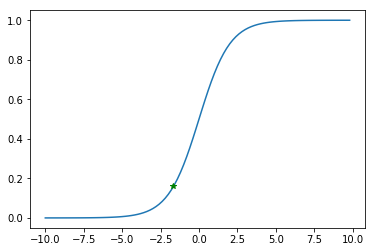

In [82]:
x = np.arange(-10., 10., 0.2)
sig = 1/(1+np.exp(-x))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(x, sig)
plt.plot(weighted_input[0][0], h[0][0], 'g*')

In [42]:
torch.mm(features, weights)

RuntimeError: size mismatch, m1: [1 x 5], m2: [1 x 5] at ..\aten\src\TH/generic/THTensorMath.cpp:961

You can do the multiplication and sum in the same operation using a matrix multiplication. In general, you'll want to use matrix multiplications since they are more efficient and accelerated using modern libraries and high-performance computing on GPUs.

Here, we want to do a matrix multiplication of the features and the weights. For this we can use [`torch.mm()`](https://pytorch.org/docs/stable/torch.html#torch.mm) or [`torch.matmul()`](https://pytorch.org/docs/stable/torch.html#torch.matmul) which is somewhat more complicated and supports broadcasting. If we try to do it with `features` and `weights` as they are, we'll get an error

```python
>> torch.mm(features, weights)

---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
<ipython-input-13-15d592eb5279> in <module>()
----> 1 torch.mm(features, weights)

RuntimeError: size mismatch, m1: [1 x 5], m2: [1 x 5] at /Users/soumith/minicondabuild3/conda-bld/pytorch_1524590658547/work/aten/src/TH/generic/THTensorMath.c:2033
```

As you're building neural networks in any framework, you'll see this often. Really often. What's happening here is our tensors aren't the correct shapes to perform a matrix multiplication. Remember that for matrix multiplications, the number of columns in the first tensor must equal to the number of rows in the second column. Both `features` and `weights` have the same shape, `(1, 5)`. This means we need to change the shape of `weights` to get the matrix multiplication to work.

**Note:** To see the shape of a tensor called `tensor`, use `tensor.shape`. If you're building neural networks, you'll be using this method often.

There are a few options here: [`weights.reshape()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.reshape), [`weights.resize_()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.resize_), and [`weights.view()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view).

* `weights.reshape(a, b)` will return a new tensor with the same data as `weights` with size `(a, b)` sometimes, and sometimes a clone, as in it copies the data to another part of memory.
* `weights.resize_(a, b)` returns the same tensor with a different shape. However, if the new shape results in fewer elements than the original tensor, some elements will be removed from the tensor (but not from memory). If the new shape results in more elements than the original tensor, new elements will be uninitialized in memory. Here I should note that the underscore at the end of the method denotes that this method is performed **in-place**. Here is a great forum thread to [read more about in-place operations](https://discuss.pytorch.org/t/what-is-in-place-operation/16244) in PyTorch.
* `weights.view(a, b)` will return a new tensor with the same data as `weights` with size `(a, b)`.

I usually use `.view()`, but any of the three methods will work for this. So, now we can reshape `weights` to have five rows and one column with something like `weights.view(5, 1)`.

> **Exercise**: Calculate the output of our little network using matrix multiplication.

In [62]:
weights, weights.view(weights.shape), weights.reshape(5, 1), weights.resize(5, 1)

(tensor([[-0.8948, -0.3556,  1.2324,  0.1382, -1.6822]]),
 tensor([[-0.8948, -0.3556,  1.2324,  0.1382, -1.6822]]),
 tensor([[-0.8948],
         [-0.3556],
         [ 1.2324],
         [ 0.1382],
         [-1.6822]]),
 tensor([[-0.8948],
         [-0.3556],
         [ 1.2324],
         [ 0.1382],
         [-1.6822]]))

In [69]:
activation(torch.sum(features * weights) + bias)

tensor([[0.1595]])

In [83]:
## Calculate the output of this network using matrix multiplication
activation(torch.mm(features, weights.reshape(tuple(reversed(weights.shape)))) + bias)

tensor([[0.1595]])

### Stack them up!

That's how you can calculate the output for a single neuron. The real power of this algorithm happens when you start stacking these individual units into layers and stacks of layers, into a network of neurons. The output of one layer of neurons becomes the input for the next layer. With multiple input units and output units, we now need to express the weights as a matrix.

<img src='assets/multilayer_diagram_weights.png' width=450px>

The first layer shown on the bottom here are the inputs, understandably called the **input layer**. The middle layer is called the **hidden layer**, and the final layer (on the right) is the **output layer**. We can express this network mathematically with matrices again and use matrix multiplication to get linear combinations for each unit in one operation. For example, the hidden layer ($h_1$ and $h_2$ here) can be calculated 

$$
\vec{h} = [h_1 \, h_2] = 
\begin{bmatrix}
x_1 \, x_2 \cdots \, x_n
\end{bmatrix}
\cdot 
\begin{bmatrix}
           w_{11} & w_{12} \\
           w_{21} &w_{22} \\
           \vdots &\vdots \\
           w_{n1} &w_{n2}
\end{bmatrix}
$$

The output for this small network is found by treating the hidden layer as inputs for the output unit. The network output is expressed simply

$$
y =  f_2 \! \left(\, f_1 \! \left(\vec{x} \, \mathbf{W_1}\right) \mathbf{W_2} \right)
$$

In [84]:
### Generate some data
torch.manual_seed(7) # Set the random seed so things are predictable

# Features are 3 random normal variables
features = torch.randn((1, 3))

# Define the size of each layer in our network
n_input = features.shape[1]     # Number of input units, must match number of input features
n_hidden = 2                    # Number of hidden units 
n_output = 1                    # Number of output units

# Weights for inputs to hidden layer
W1 = torch.randn(n_input, n_hidden)
# Weights for hidden layer to output layer
W2 = torch.randn(n_hidden, n_output)

# and bias terms for hidden and output layers
B1 = torch.randn((1, n_hidden))
B2 = torch.randn((1, n_output))

> **Exercise:** Calculate the output for this multi-layer network using the weights `W1` & `W2`, and the biases, `B1` & `B2`. 

In [90]:
## Your solution here
hidden_layer = activation(torch.mm(features, W1) + B1)
print(hidden_layer)
output_layer = activation(torch.mm(hidden_layer, W2) + B2)
print(output_layer)

tensor([[0.6813, 0.4355]])
tensor([[0.3171]])


If you did this correctly, you should see the output `tensor([[ 0.3171]])`.

The number of hidden units a parameter of the network, often called a **hyperparameter** to differentiate it from the weights and biases parameters. As you'll see later when we discuss training a neural network, the more hidden units a network has, and the more layers, the better able it is to learn from data and make accurate predictions.

## Numpy to Torch and back

Special bonus section! PyTorch has a great feature for converting between Numpy arrays and Torch tensors. To create a tensor from a Numpy array, use `torch.from_numpy()`. To convert a tensor to a Numpy array, use the `.numpy()` method.

In [91]:
import numpy as np
a = np.random.rand(4,3)
a

array([[0.05292868, 0.987411  , 0.00837462],
       [0.36972374, 0.82854178, 0.86705591],
       [0.0511617 , 0.30459555, 0.24500715],
       [0.59285561, 0.70337996, 0.71036257]])

In [92]:
b = torch.from_numpy(a)
b

tensor([[0.0529, 0.9874, 0.0084],
        [0.3697, 0.8285, 0.8671],
        [0.0512, 0.3046, 0.2450],
        [0.5929, 0.7034, 0.7104]], dtype=torch.float64)

In [93]:
b.numpy()

array([[0.05292868, 0.987411  , 0.00837462],
       [0.36972374, 0.82854178, 0.86705591],
       [0.0511617 , 0.30459555, 0.24500715],
       [0.59285561, 0.70337996, 0.71036257]])

The memory is shared between the Numpy array and Torch tensor, so if you change the values in-place of one object, the other will change as well.

In [94]:
# Multiply PyTorch Tensor by 2, in place
b.mul_(2)

tensor([[0.1059, 1.9748, 0.0167],
        [0.7394, 1.6571, 1.7341],
        [0.1023, 0.6092, 0.4900],
        [1.1857, 1.4068, 1.4207]], dtype=torch.float64)

In [95]:
# Numpy array matches new values from Tensor
a

array([[0.10585737, 1.97482201, 0.01674925],
       [0.73944748, 1.65708357, 1.73411183],
       [0.10232341, 0.60919109, 0.4900143 ],
       [1.18571121, 1.40675992, 1.42072515]])